In [365]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import *
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit_aer import *
from qiskit.circuit.library import IntegerComparator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [366]:
backend = Aer.get_backend('qasm_simulator')
from math import *
print(backend.name)
def initialize_circuit(int_list, K):
    N = len(int_list)
    n = ceil(log2(N))  # Number of qubits for index register
    m = ceil(log2(max(int_list) + 1))  # Number of qubits for data register

    # Get the number of ancillas required by the comparator
    _, num_comp_ancillas = comparator_circuit(m, K)
    num_ancilla = 1 + num_comp_ancillas  # 1 for comparator output, rest for ancillas

    total_qubits = n + m + num_ancilla
    qc = QuantumCircuit(total_qubits, n)  # Classical bits for measurement

    return qc, n, m, num_comp_ancillas

qasm_simulator


In [367]:
def load_data_circuit(int_list, n, m):
    qc = QuantumCircuit(n + m)
    for i, a_i in enumerate(int_list):
        index_bin = format(i, f'0{n}b')
        data_bin = format(a_i, f'0{m}b')

        # Prepare index qubits for |i⟩
        for idx, bit in enumerate(reversed(index_bin)):
            if bit == '0':
                qc.x(idx)

        # Load a_i into data register using multi-controlled X gates
        for d_idx, bit in enumerate(reversed(data_bin)):
            if bit == '1':
                qc.mcx(list(range(n)), n + d_idx)

        # Reset index qubits
        for idx, bit in enumerate(reversed(index_bin)):
            if bit == '0':
                qc.x(idx)

    return qc.to_gate(label='LoadData')

In [368]:
def comparator_circuit(m, K):
    # Create the comparator circuit
    comparator = IntegerComparator(
        num_state_qubits=m,
        value=K,
        geq=False,  # Less than k
        name='Comparator'
    )
    # Return the comparator gate and number of ancilla qubits
    return comparator.to_gate(), comparator.num_ancillas

In [369]:
def build_grover_circuit(int_list, K):
    qc, n, m, num_comp_ancillas = initialize_circuit(int_list, K)
    total_qubits = n + m + 1 + num_comp_ancillas  # +1 for comparator output

    index_qubits = list(range(n))

    # Initialize index qubits in superposition
    qc.h(index_qubits)

    # Prepare the oracle and diffusion operator
    oracle_gate = grover_oracle(int_list, K, n, m)
    diffusion_gate = diffusion_operator(n)

    # Estimate number of Grover iterations
    N = 2 ** n
    M = len([a for a in int_list if a < K])
    if M == 0:
        print("No elements less than k.")
        return qc

    num_iterations = int(round((pi / 4) * sqrt(N / M)))

    # Apply Grover iterations
    for _ in range(num_iterations):
        qc.append(oracle_gate, range(total_qubits))
        qc.append(diffusion_gate, index_qubits)

    # Measure index qubits
    qc.measure(index_qubits, qc.clbits[:n])

    return qc

In [370]:
def diffusion_operator(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))

    # Multi-controlled Z gate
    if n > 1:
        qc.h(n - 1)
        qc.mcx(list(range(n - 1)), n - 1)
        qc.h(n - 1)
    else:
        qc.z(0)

    qc.x(range(n))
    qc.h(range(n))

    return qc.to_gate(label='Diffusion')

In [371]:
def run_grover(int_list, K):
    qc = build_grover_circuit(int_list, K)
    backend = Aer.get_backend('qasm_simulator')
    transpiled_qc = transpile(qc, backend)
    result = backend.run(transpiled_qc).result()
    # sampler = Sampler(backend)
    # result = sampler.run([transpiled_qc]).result()
    cs = result.get_counts()
    print(cs)

    n = ceil(log2(len(int_list)))
    found_indices = []
    for measured_state in cs:
        index = int(measured_state[:n], 2)
        if index < len(int_list) and int_list[index] < K:
            found_indices.append(index)

    found_values = [int_list[i] for i in found_indices]

    print("Indices of elements less than k:", found_indices)
    print("Elements less than k:", found_values)
    return cs

In [372]:
def grover_oracle(int_list, K, n, m):
    # Get the comparator gate and number of ancilla qubits
    comparator, num_comp_ancillas = comparator_circuit(m, K)

    total_qubits = n + m + 1 + num_comp_ancillas  # +1 for comparator output
    qc = QuantumCircuit(total_qubits)

    index_qubits = list(range(n))
    data_qubits = list(range(n, n + m))
    ancilla_qubit = n + m  # Output qubit of comparator
    comp_ancilla_qubits = list(range(n + m + 1, total_qubits))  # Comparator ancillas

    # Load data into data register
    load_data = load_data_circuit(int_list, n, m)
    qc.append(load_data, index_qubits + data_qubits)

    # Apply comparator circuit
    comparator_qubits = data_qubits + [ancilla_qubit] + comp_ancilla_qubits
    qc.append(comparator, comparator_qubits)

    # Phase flip the state if ancilla qubit is |1⟩
    qc.z(ancilla_qubit)

    # Uncompute comparator and data loading
    qc.append(comparator.inverse(), comparator_qubits)
    qc.append(load_data.inverse(), index_qubits + data_qubits)

    return qc.to_gate(label='Oracle')


{'1001': 2, '1010': 7, '0101': 191, '0110': 7, '0011': 7, '0001': 190, '1101': 4, '1111': 7, '0111': 178, '1011': 3, '0000': 7, '0010': 208, '0100': 4, '1100': 4, '1110': 6, '1000': 199}
Indices of elements less than K: [9, 6, 3, 0, 4]
Elements less than K: [4, 2, 1, 4, 2]


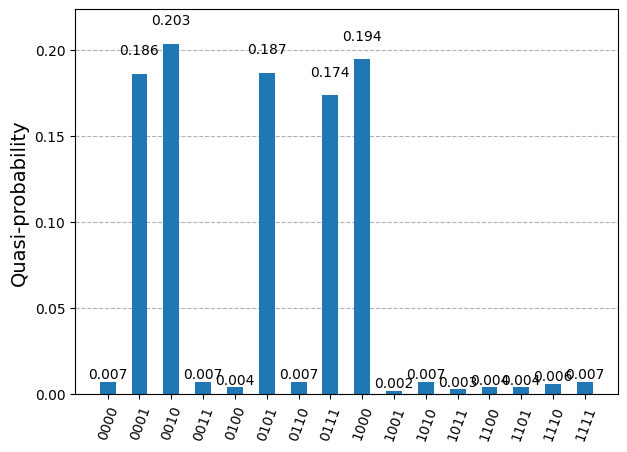

In [373]:
int_list = [4, 6, 9, 1, 2, 5, 2, 11, 15, 4]
# result should be [4, 1, 2, 2, 4]
K = 5

counts = run_grover(int_list, K)
plot_distribution(counts)